# Network Disruptions Detection

The goal of the problem is to predict a network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 

Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). 

Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. 

Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. "severity_type" is categorical. It does not have an ordering. “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

File descriptions
- train.csv - the training set for the fault severity
- test.csv - the test set for fault severity
- sample_submission.csv – a sample of the correct format for the input
- event_type.csv: type of event related to the main dataset
- log_feature.csv - features extracted from log files
- resource_type.csv: resource type related to the main dataset
- severity_type.csv: severity type of a warning message coming from the log

# We import libraries and data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

%matplotlib inline
sns.set()

In [2]:
event= pd.read_csv('event_type.csv')
event.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [3]:
log_feature= pd.read_csv('log_feature.csv')
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [4]:
resource_type= pd.read_csv('resource_type.csv')
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [5]:
severity_type= pd.read_csv('severity_type.csv')
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [6]:
attack_intensity = pd.read_csv('train.csv')
attack_intensity.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [7]:
#to see the shapes:
print('Attack Intensity: ', attack_intensity.shape)
print ('severity_type: ', severity_type.shape)
print ('event: ', event.shape)
print ('resource_type: ', resource_type.shape)
print ('log_feature: ', log_feature.shape)


Attack Intensity:  (7381, 3)
severity_type:  (18552, 2)
event:  (31170, 2)
resource_type:  (21076, 2)
log_feature:  (58671, 3)


gathering for **train**:

In [8]:
df = attack_intensity.merge(severity_type, how = 'left', left_on='id', right_on='id')
df.head()

,id,location,fault_severity,severity_type
0,14121,location 118,1,severity_type 2
1,9320,location 91,0,severity_type 2
2,14394,location 152,1,severity_type 2
3,8218,location 931,1,severity_type 1
4,14804,location 120,0,severity_type 1


In [9]:
df = df.merge(event, how = 'left', left_on='id', right_on='id')
df.head()

,id,location,fault_severity,severity_type,event_type
0,14121,location 118,1,severity_type 2,event_type 34
1,14121,location 118,1,severity_type 2,event_type 35
2,9320,location 91,0,severity_type 2,event_type 34
3,9320,location 91,0,severity_type 2,event_type 35
4,14394,location 152,1,severity_type 2,event_type 35


In [10]:
df = df.merge(resource_type, how= 'left', left_on='id', right_on='id')
df.head()

,id,location,fault_severity,severity_type,event_type,resource_type
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2
1,14121,location 118,1,severity_type 2,event_type 35,resource_type 2
2,9320,location 91,0,severity_type 2,event_type 34,resource_type 2
3,9320,location 91,0,severity_type 2,event_type 35,resource_type 2
4,14394,location 152,1,severity_type 2,event_type 35,resource_type 2


In [11]:
df = df.merge(log_feature, how='left', left_on='id', right_on='id')
df.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 312,19
1,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 232,19
2,14121,location 118,1,severity_type 2,event_type 35,resource_type 2,feature 312,19
3,14121,location 118,1,severity_type 2,event_type 35,resource_type 2,feature 232,19
4,9320,location 91,0,severity_type 2,event_type 34,resource_type 2,feature 315,200


We can see that there are repeated records, so we proceed to eliminate them according to the `id`.

In [12]:
df.drop_duplicates(subset='id', inplace=True)

In [13]:
df.reset_index(inplace=True, drop=True)

In [14]:
df.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,location 118,1,severity_type 2,event_type 34,resource_type 2,feature 312,19
1,9320,location 91,0,severity_type 2,event_type 34,resource_type 2,feature 315,200
2,14394,location 152,1,severity_type 2,event_type 35,resource_type 2,feature 221,1
3,8218,location 931,1,severity_type 1,event_type 15,resource_type 8,feature 80,9
4,14804,location 120,0,severity_type 1,event_type 34,resource_type 2,feature 134,1


In [15]:
df.shape

(7381, 8)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
 3   severity_type   7381 non-null   object
 4   event_type      7381 non-null   object
 5   resource_type   7381 non-null   object
 6   log_feature     7381 non-null   object
 7   volume          7381 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 461.4+ KB


## **Merging Test Data**

In [17]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [18]:
#to see the shapes:
print('Test_data')
print ('severity_type')
print ('event')
print ('resource_type')
print ("log_feature")


Test_data
severity_type
event
resource_type
log_feature


In [19]:
test_df = test_data.merge(severity_type, how= 'left', left_on='id', right_on='id')
test_df .head()

,id,location,severity_type
0,11066,location 481,severity_type 2
1,18000,location 962,severity_type 1
2,16964,location 491,severity_type 2
3,4795,location 532,severity_type 5
4,3392,location 600,severity_type 2


In [20]:
test_df = test_df.merge(event, how= 'left', left_on='id', right_on='id')
test_df.head()

,id,location,severity_type,event_type
0,11066,location 481,severity_type 2,event_type 35
1,11066,location 481,severity_type 2,event_type 34
2,18000,location 962,severity_type 1,event_type 11
3,18000,location 962,severity_type 1,event_type 15
4,16964,location 491,severity_type 2,event_type 35


In [21]:
test_df = test_df.merge(resource_type, how= 'left', left_on='id', right_on='id')
test_df .head()

,id,location,severity_type,event_type,resource_type
0,11066,location 481,severity_type 2,event_type 35,resource_type 2
1,11066,location 481,severity_type 2,event_type 34,resource_type 2
2,18000,location 962,severity_type 1,event_type 11,resource_type 8
3,18000,location 962,severity_type 1,event_type 15,resource_type 8
4,16964,location 491,severity_type 2,event_type 35,resource_type 2


In [22]:
test_df = test_df .merge(log_feature, how='left', left_on='id', right_on='id')
test_df .head()

,id,location,severity_type,event_type,resource_type,log_feature,volume
0,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 230,24
1,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 310,28
2,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 228,20
3,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 308,26
4,11066,location 481,severity_type 2,event_type 34,resource_type 2,feature 230,24


Dropping Duplicate Values.

In [23]:
test_df.drop_duplicates(subset='id', inplace=True)

In [24]:
test_df.reset_index(inplace=True, drop=True)

In [25]:
test_df.head()

,id,location,severity_type,event_type,resource_type,log_feature,volume
0,11066,location 481,severity_type 2,event_type 35,resource_type 2,feature 230,24
1,18000,location 962,severity_type 1,event_type 11,resource_type 8,feature 203,9
2,16964,location 491,severity_type 2,event_type 35,resource_type 2,feature 235,10
3,4795,location 532,severity_type 5,event_type 27,resource_type 3,feature 240,1
4,3392,location 600,severity_type 2,event_type 15,resource_type 8,feature 82,6


In [26]:
test_df.shape

(11171, 7)

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             11171 non-null  int64 
 1   location       11171 non-null  object
 2   severity_type  11171 non-null  object
 3   event_type     11171 non-null  object
 4   resource_type  11171 non-null  object
 5   log_feature    11171 non-null  object
 6   volume         11171 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 611.0+ KB


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
 3   severity_type   7381 non-null   object
 4   event_type      7381 non-null   object
 5   resource_type   7381 non-null   object
 6   log_feature     7381 non-null   object
 7   volume          7381 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 461.4+ KB


### **Checking If there are any null values avaliable**

In [29]:
#Let's see if there are missing values
df.isnull().sum()

id                0
location          0
fault_severity    0
severity_type     0
event_type        0
resource_type     0
log_feature       0
volume            0
dtype: int64

### **Data Preprocessing (Converting String to Integer)**

In [30]:
df['location'] = df['location'].str.split(' ')
df['location'] = df['location'].str.get(1)

df['severity_type'] = df['severity_type'].str.split(' ')
df['severity_type'] = df['severity_type'].str.get(1)

df['event_type'] = df['event_type'].str.split(' ')
df['event_type'] = df['event_type'].str.get(1)

df['log_feature'] = df['log_feature'].str.split(' ')
df['log_feature'] = df['log_feature'].str.get(1)

df['resource_type'] = df['resource_type'].str.split(' ')
df['resource_type'] = df['resource_type'].str.get(1)


In [31]:
df = df.apply(pd.to_numeric)

## **Data Visualizations**

In [32]:
import bokeh
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure, show

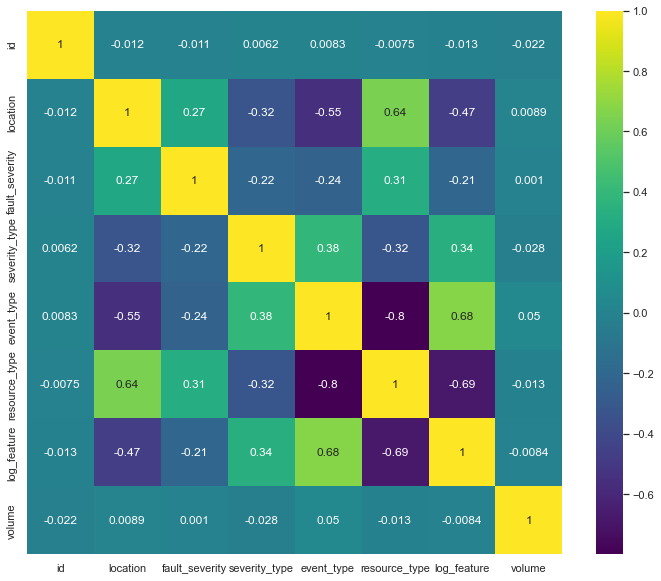

In [33]:
#with a seaborn heatmap
plt.figure(figsize = (12,10))
corr = df.corr()
sns.heatmap(data = corr, yticklabels=True, cbar=True, cmap="viridis", annot = True)
plt.show()

## **Exploratory Data Analysis.**

In [34]:
#To view unique values ​​by column:
print ('unique for location: ', df.location.unique)
print ('unique for fault_severity: ', df.fault_severity.unique)
print ('unique for severity_type: ', df.severity_type.unique)
print ('unique for event_type: ', df.event_type.unique)
print ('unique for resource_type: ', df.resource_type.unique)
print ('unique for log_feature: ', df.log_feature.unique)
print ('unique for volume: ', df.volume.unique)

unique for location:  <bound method Series.unique of 0        118
1         91
2        152
3        931
4        120
        ... 
7376     167
7377     106
7378    1086
7379       7
7380     885
Name: location, Length: 7381, dtype: int64>
unique for fault_severity:  <bound method Series.unique of 0       1
1       0
2       1
3       1
4       0
       ..
7376    0
7377    0
7378    2
7379    0
7380    0
Name: fault_severity, Length: 7381, dtype: int64>
unique for severity_type:  <bound method Series.unique of 0       2
1       2
2       2
3       1
4       1
       ..
7376    2
7377    1
7378    2
7379    1
7380    1
Name: severity_type, Length: 7381, dtype: int64>
unique for event_type:  <bound method Series.unique of 0       34
1       34
2       35
3       15
4       34
        ..
7376    34
7377    20
7378    15
7379    11
7380    11
Name: event_type, Length: 7381, dtype: int64>
unique for resource_type:  <bound method Series.unique of 0       2
1       2
2       2
3       8
4   

## **A general view.**

To see the number of cases according to **fault_severity**:

In [35]:
#To display the data according to l2
df_fs = df.groupby('fault_severity', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
df_fs

,fault_severity,size
1,0,4784
0,1,1871
2,2,726


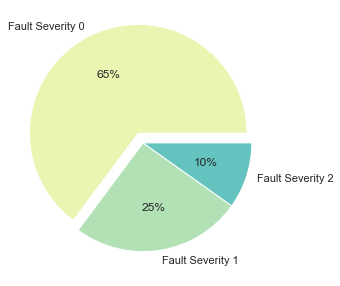

In [36]:
plt.figure(figsize=(10,5))

data = [4784, 1871, 726]
keys = ['Fault Severity 0','Fault Severity 1', 'Fault Severity 2']
  
# declaring exploding pie
explode = [0.1, 0, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('YlGnBu')
  
# plotting data on chart
plt.pie(data ,labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
  
# displaying chart
plt.show()

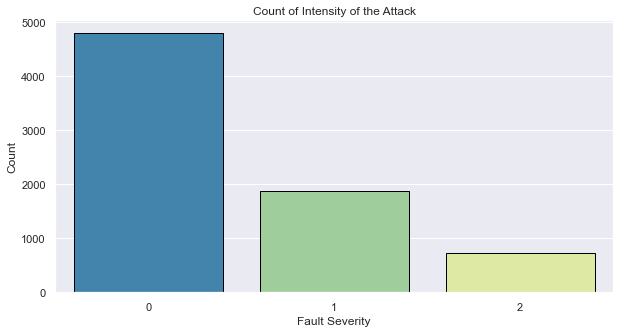

In [37]:
plt.figure(figsize=(10,5))
sns.countplot(data = df, x='fault_severity', lw=1, edgecolor="black", palette=Spectral6, color = "#007ACC")
plt.title ('Count of Intensity of the Attack')
plt.xlabel('Fault Severity')
plt.ylabel('Count')
plt.show()

<Figure size 864x720 with 0 Axes>

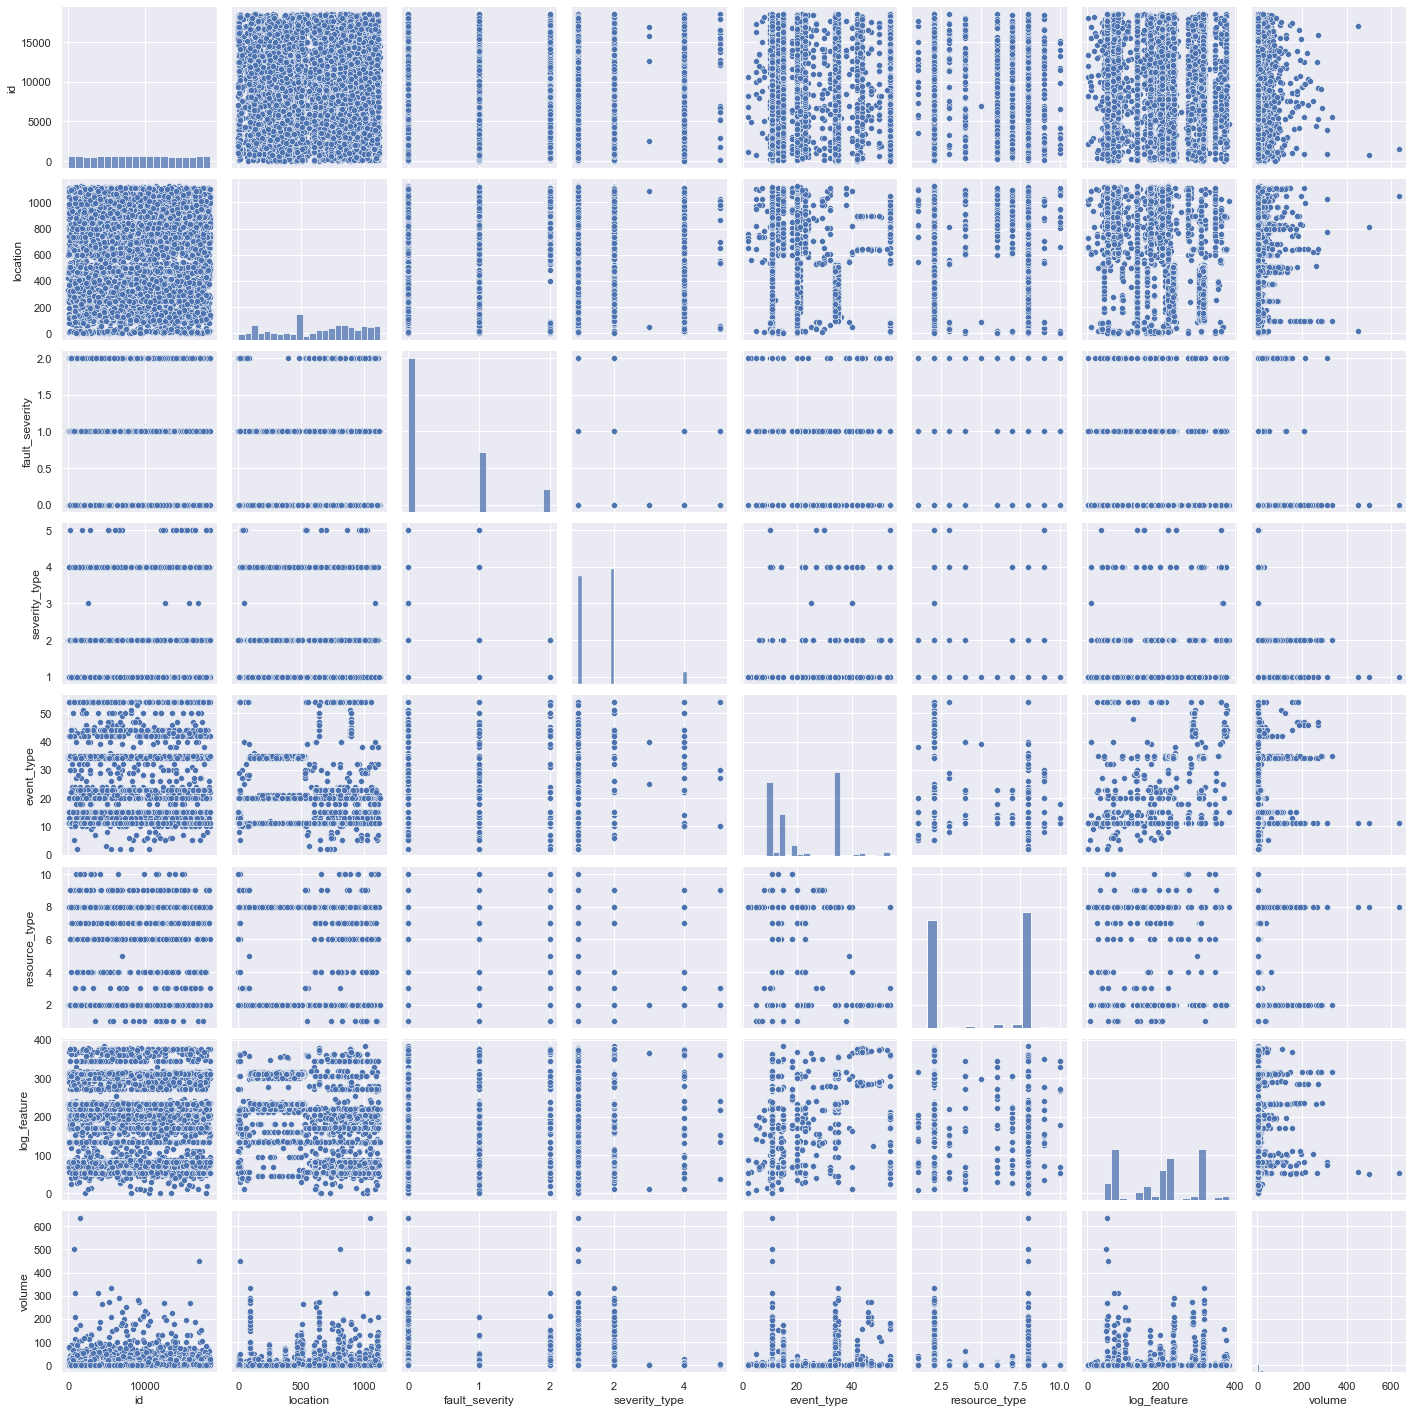

In [38]:
plt.figure(figsize = (12,10))
sns.pairplot(df, palette=Spectral6)
plt.show()

We can see that there are more non-failures than failures. 1 o 2.

To see the number of cases according to **severity_type**:

In [39]:
df_st = df.groupby('severity_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
df_st

,severity_type,size
0,2,3591
1,1,3375
2,4,388
3,5,23
4,3,4


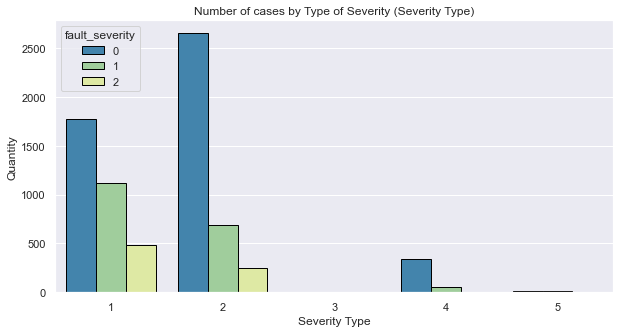

In [40]:
plt.figure(figsize=(10,5))
sns.countplot(data = df, x='severity_type', hue = 'fault_severity',lw=1, edgecolor="black",palette=Spectral6, color = "#007ACC")
plt.title ('Number of cases by Type of Severity (Severity Type)')
plt.xlabel('Severity Type')
plt.ylabel('Quantity')
plt.show()

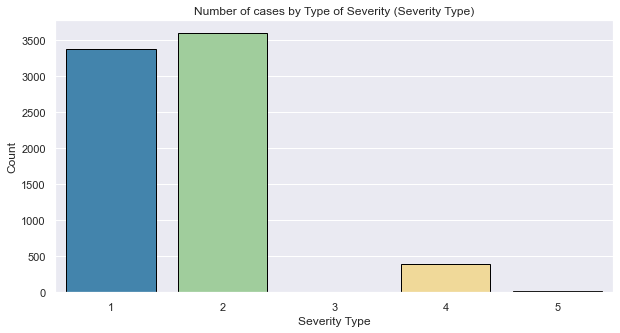

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(data = df, x='severity_type',lw=1, edgecolor="black",palette=Spectral6, color = "#007ACC")
plt.title ('Number of cases by Type of Severity (Severity Type)')
plt.xlabel('Severity Type')
plt.ylabel('Count')
plt.show()

With this information we can see that the faults that occur most are those of type 1 and 2. Those that severities type 4, 5 and 3 occur very little (compared to types 1 and 2).

To see the number of cases according to **resource_type**:

In [42]:
df_rt = df.groupby('resource_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
df_rt

,resource_type,size
1,8,3599
0,2,3369
4,6,121
2,7,119
3,4,57
5,9,52
7,3,32
8,10,16
6,1,15
9,5,1


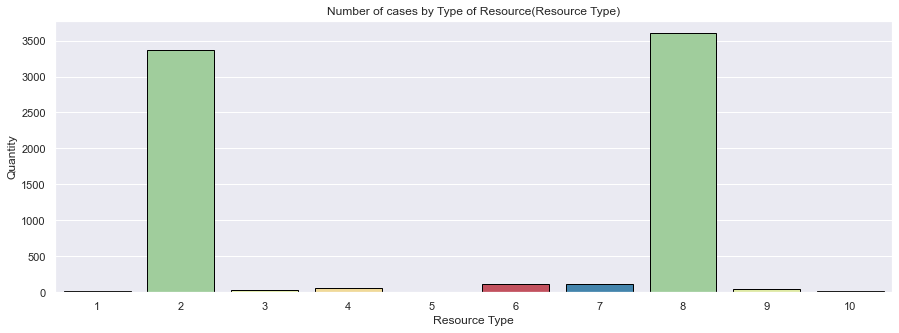

In [43]:
plt.figure(figsize=(15,5))
sns.barplot(data = df_rt, x='resource_type', y= 'size',lw=1, edgecolor="black", palette=Spectral6, color = "#007ACC")
plt.title ('Number of cases by Type of Resource(Resource Type)')
plt.xlabel('Resource Type')
plt.ylabel('Quantity')
plt.show()

The most used types of resources are: 2 and 8. While the rest of the resources have relatively few cases.

To see the number of cases by location:

In [44]:
df_loc = df.groupby('location', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
df_loc

,location,size
124,821,85
50,1107,78
118,734,75
179,126,71
60,1008,71
...,...,...
175,1122,1
729,813,1
731,589,1
736,117,1


C:\Users\AB\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


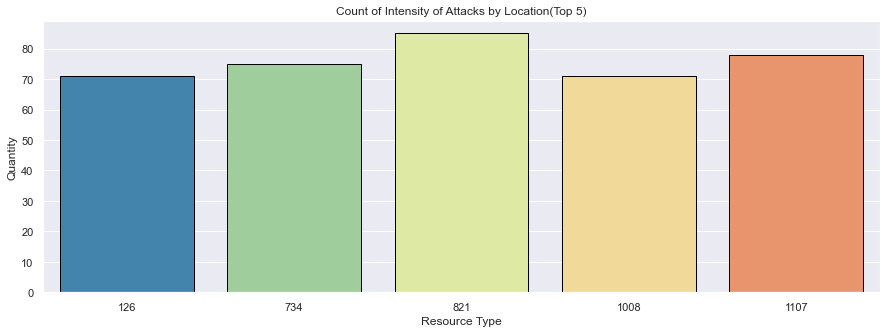

In [45]:
plt.figure(figsize=(15,5))
sns.barplot(df_loc['location'][:5],df_loc['size'][:5], lw=1, edgecolor="black", palette=Spectral6, color = "#007ACC")
plt.title ('Count of Intensity of Attacks by Location(Top 5)')
plt.xlabel('Resource Type')
plt.ylabel('Quantity')
plt.show()

C:\Users\AB\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


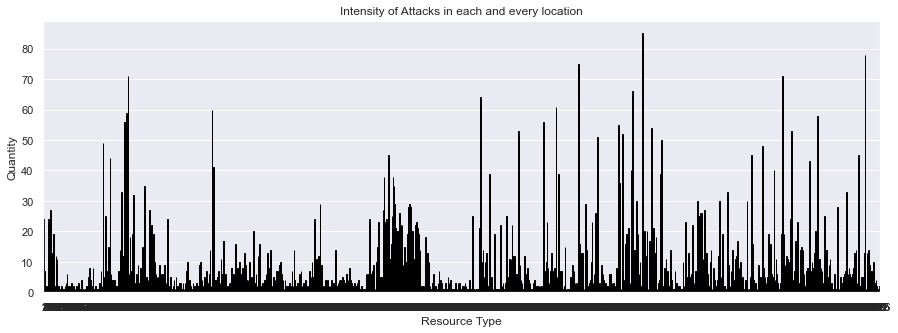

In [46]:
plt.figure(figsize=(15,5))
sns.barplot(df_loc['location'],df_loc['size'], lw=1, edgecolor="black", palette=Spectral6, color = "#007ACC")
plt.title ('Intensity of Attacks in each and every location')
plt.xlabel('Resource Type')
plt.ylabel('Quantity')
plt.show()

The 5 locations that have the most cases are: 821, 1107, 734, 126 and 1008.

## fault_severity = 1

Let's analyze type 1 faults to see what we can find

In [47]:
faults_type_1= df[df.fault_severity == 1]

In [48]:
faults_type_1.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,118,1,2,34,2,312,19
2,14394,152,1,2,35,2,221,1
3,8218,931,1,1,15,8,80,9
8,3443,263,1,2,34,2,312,1
9,13300,613,1,1,54,8,71,1


In [49]:
faults_type_1.shape

(1871, 8)

In [50]:
ft1_et = faults_type_1.groupby('event_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft1_et

,event_type,size
4,11,713
2,15,346
0,34,194
1,35,186
8,13,75
5,20,74
3,54,51
11,23,38
6,42,27
7,14,24


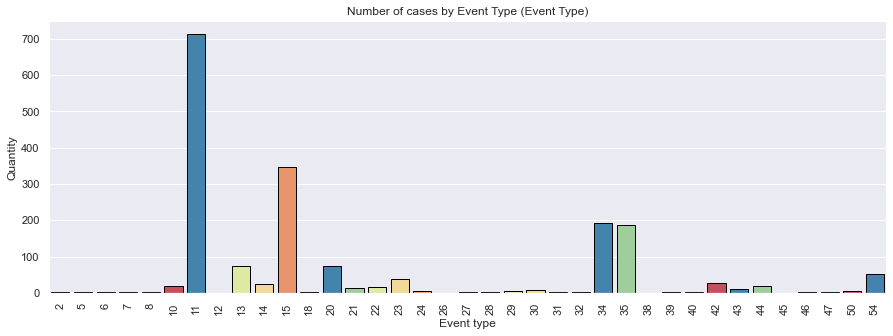

In [51]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft1_et, x='event_type', y='size', lw=1, edgecolor="black", palette=Spectral6, color = "#007ACC")
plt.title ('Number of cases by Event Type (Event Type)')
plt.xlabel('Event type')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
plt.show()

## fault_severity = 2

Let's analyze type 1 faults to see what we can find

In [52]:
faults_type_2= df[df.fault_severity == 2]

In [53]:
faults_type_2.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
38,4311,704,2,1,15,8,74,1
39,12261,1089,2,1,11,8,170,11
41,14992,600,2,2,15,8,203,1
42,967,892,2,1,42,2,291,5
46,3945,684,2,2,15,8,71,1


In [54]:
ft2_loc = faults_type_2.groupby('location', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft2_loc

,location,size
6,1107,33
28,1100,33
43,734,30
2,600,29
15,821,28
...,...,...
97,541,1
96,531,1
95,687,1
94,610,1


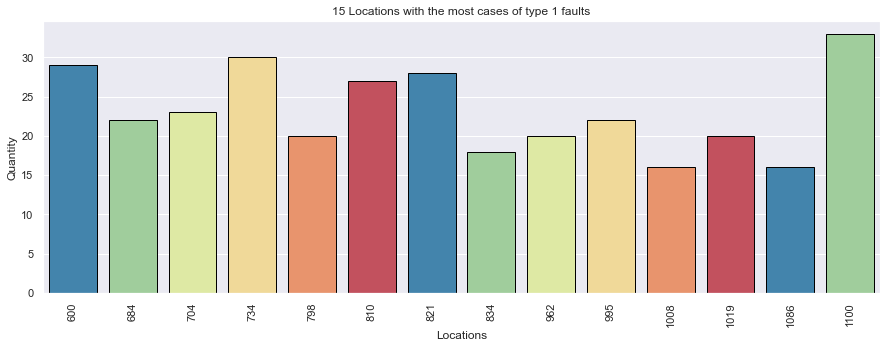

In [55]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft2_loc[1:15], x='location', y='size', lw=1, edgecolor="black", palette = Spectral6, color = "#007ACC")
plt.title ('15 Locations with the most cases of type 1 faults')
plt.xlabel('Locations')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
plt.show()

In [56]:
ft2_et = faults_type_2.groupby('event_type', sort=False, as_index=False).size().sort_values(by="size",ascending=False)
ft2_et

,event_type,size
0,15,370
1,11,241
4,54,26
7,44,23
5,13,14
2,42,10
6,20,9
9,43,6
10,14,6
21,22,3


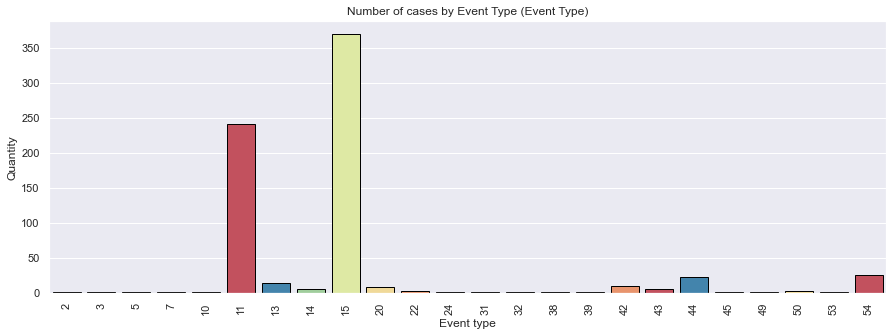

In [57]:
plt.figure(figsize=(15,5))
sns.barplot(data = ft2_et, x='event_type', y='size', lw=1, edgecolor="black", palette=Spectral6, color = "#007ACC")
plt.title ('Number of cases by Event Type (Event Type)')
plt.xlabel('Event type')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
plt.show()

In [58]:
type(df)

pandas.core.frame.DataFrame

## **Data Transformation**

In [59]:
df.head()

,id,location,fault_severity,severity_type,event_type,resource_type,log_feature,volume
0,14121,118,1,2,34,2,312,19
1,9320,91,0,2,34,2,315,200
2,14394,152,1,2,35,2,221,1
3,8218,931,1,1,15,8,80,9
4,14804,120,0,1,34,2,134,1


In [60]:
target_var = df['fault_severity']
independent_features = df.drop(columns = ['id','fault_severity'])

In [61]:
df = pd.get_dummies(independent_features, columns = ['severity_type', 'resource_type'])
df.head()


,location,event_type,log_feature,volume,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5,resource_type_1,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9,resource_type_10
0,118,34,312,19,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,91,34,315,200,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,152,35,221,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,931,15,80,9,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,120,34,134,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [62]:
sc = StandardScaler()
col_to_scale = ['location', 'event_type', 'log_feature', 'volume']
df[col_to_scale] = sc.fit_transform(df[col_to_scale])

In [63]:
df.head()

,location,event_type,log_feature,volume,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5,resource_type_1,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9,resource_type_10
0,-1.579268,0.939010,1.251767,0.442675,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,-1.663485,0.939010,1.283200,8.132431,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,-1.473217,1.023377,0.298293,-0.322052,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0.956600,-0.663963,-1.179069,0.017826,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,-1.573029,0.939010,-0.613271,-0.322052,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Resampling

In [64]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [65]:
X = df
y = target_var

In [66]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [67]:
print(X.shape)

(14352, 19)


In [68]:
print(y.shape)

(14352,)


Class=1, n=4784 (33.333%)
Class=0, n=4784 (33.333%)
Class=2, n=4784 (33.333%)


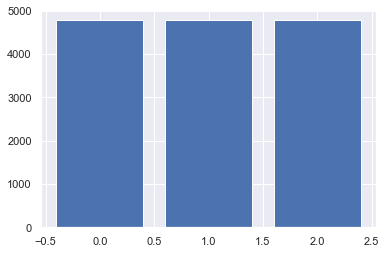

In [69]:
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## **Model Building**

In [70]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

In [71]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [72]:
def resultados (y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, cbar= True,  square= True, annot=True, fmt= '.0f',
           cmap= 'YlGnBu', linewidths=.5);
    plt.title('Confusion matrix')
    plt.ylabel('Predicted Values')
    plt.xlabel('Actual Values')
    plt.show()

# Support Vector Machine

In [73]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred_svc = svc_clf.predict(X_test)

print_score(svc_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svc_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 61.82%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.697585     0.536842     0.615097  0.618172     0.616508   
recall        0.609797     0.438144     0.795161  0.618172     0.614368   
f1-score      0.650744     0.482498     0.693633  0.618172     0.608958   
support    1184.000000  1164.000000  1240.000000  0.618172  3588.000000   

           weighted avg  
precision      0.616930  
recall         0.618172  
f1-score       0.610985  
support     3588.000000  
_______________________________________________
Confusion Matrix: 
 [[722 214 248]
 [285 510 369]
 [ 28 226 986]]

Test Result:
Accuracy Score: 59.88%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.649460     0.528993     0.604847  0.598848      0.594433   
recall      

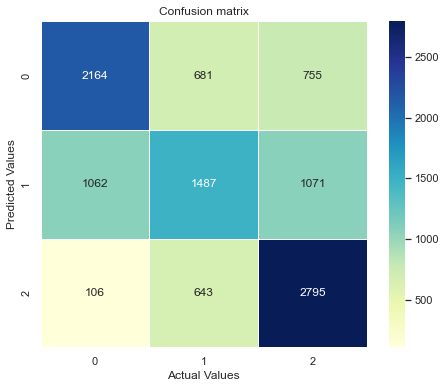

In [74]:
resultados(y_test, y_pred_svc)

# Decision Tree

In [75]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_tree = dt_clf.predict(X_test)

print_score(dt_clf, X_train, y_train, X_test, y_test, train=True)
print_score(dt_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.53%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.990780     0.994836     1.000000  0.995262     0.995205   
recall        0.998311     0.993127     0.994355  0.995262     0.995264   
f1-score      0.994531     0.993981     0.997169  0.995262     0.995227   
support    1184.000000  1164.000000  1240.000000  0.995262  3588.000000   

           weighted avg  
precision      0.995282  
recall         0.995262  
f1-score       0.995264  
support     3588.000000  
_______________________________________________
Confusion Matrix: 
 [[1182    2    0]
 [   8 1156    0]
 [   3    4 1233]]

Test Result:
Accuracy Score: 67.20%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.672603     0.611467     0.733030  0.671962      0.672367   
rec

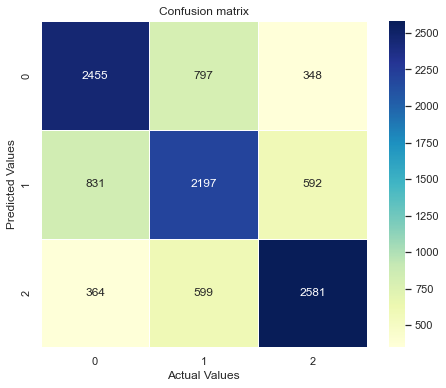

In [76]:
resultados(y_test, y_pred_tree)

# Random Forest Classifier

In [77]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.53%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.995766     0.992295     0.997579  0.995262     0.995213   
recall        0.993243     0.995704     0.996774  0.995262     0.995241   
f1-score      0.994503     0.993997     0.997176  0.995262     0.995225   
support    1184.000000  1164.000000  1240.000000  0.995262  3588.000000   

           weighted avg  
precision      0.995266  
recall         0.995262  
f1-score       0.995263  
support     3588.000000  
_______________________________________________
Confusion Matrix: 
 [[1176    6    2]
 [   4 1159    1]
 [   1    3 1236]]

Test Result:
Accuracy Score: 74.35%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.748766     0.699598     0.778588  0.743497      0.742317   
rec

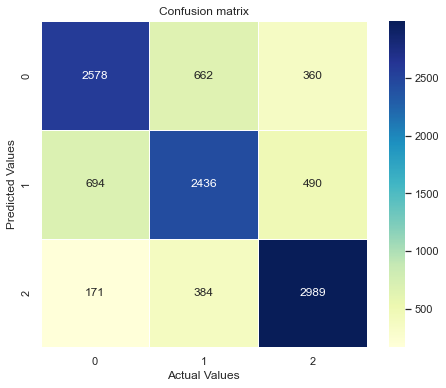

In [78]:
resultados(y_test, y_pred_rf)

# KNearest Neighbour

Train Result:
Accuracy Score: 78.54%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.806883     0.732730     0.816742  0.785396     0.785452   
recall        0.712838     0.765464     0.873387  0.785396     0.783896   
f1-score      0.756951     0.748739     0.844115  0.785396     0.783269   
support    1184.000000  1164.000000  1240.000000  0.785396  3588.000000   

           weighted avg  
precision      0.786234  
recall         0.785396  
f1-score       0.784411  
support     3588.000000  
_______________________________________________
Confusion Matrix: 
 [[ 844  218  122]
 [ 152  891  121]
 [  50  107 1083]]

Test Result:
Accuracy Score: 68.58%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.686663     0.634964     0.734850  0.685805      0.685492   
rec

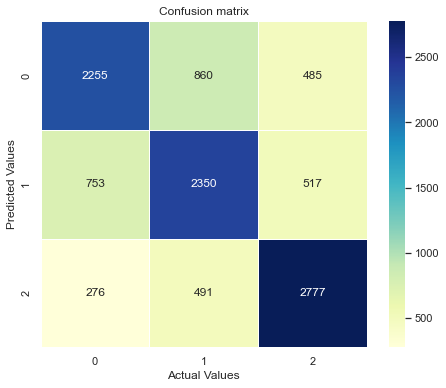

In [79]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)
resultados(y_test, y_pred_knn)

# GaussianNB

Train Result:
Accuracy Score: 39.63%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.828571     0.670807     0.369356  0.396321     0.622912   
recall        0.073480     0.092784     0.989516  0.396321     0.385260   
f1-score      0.134988     0.163019     0.537922  0.396321     0.278643   
support    1184.000000  1164.000000  1240.000000  0.396321  3588.000000   

           weighted avg  
precision      0.618687  
recall         0.396321  
f1-score       0.283334  
support     3588.000000  
_______________________________________________
Confusion Matrix: 
 [[  87   42 1055]
 [  16  108 1040]
 [   2   11 1227]]

Test Result:
Accuracy Score: 37.72%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.749206     0.658683     0.351226  0.377183      0.586372   
rec

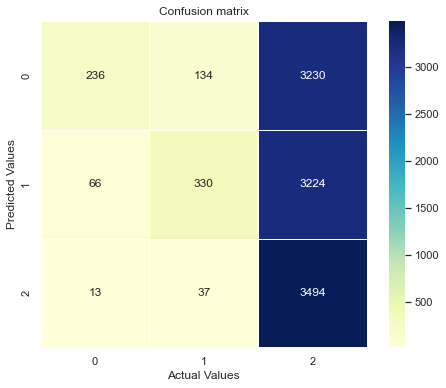

In [80]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
y_pred_gnb = gnb_clf.predict(X_test)

print_score(gnb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(gnb_clf, X_train, y_train, X_test, y_test, train=False)
resultados(y_test, y_pred_gnb)

# Improving the Best Model

In [81]:
#Make the grid for Grid Search:
param_grid = {'n_estimators': [200, 300, 400, 500],   
              'min_samples_split': [2,3,4,5],    
              'min_samples_leaf':[1,3,5]}   

In [82]:
model = GridSearchCV(rf_clf, param_grid=param_grid, cv=5)

In [83]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [200, 300, 400, 500]})

In [84]:
print("Best parameters: "+str(model.best_params_))
print("Best Score: "+str(model.best_score_)+'\n')

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Best Score: 0.7408068282032454



In [85]:
rf_clf_2 = RandomForestClassifier(min_samples_leaf=3, min_samples_split=3, n_estimators=300)

In [86]:
rf_clf_2.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=3,
                       n_estimators=300)

In [87]:
y_pred_forest2= rf_clf_2.predict(X_test)

Train Result:
Accuracy Score: 99.53%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy    macro avg  \
precision     0.995766     0.992295     0.997579  0.995262     0.995213   
recall        0.993243     0.995704     0.996774  0.995262     0.995241   
f1-score      0.994503     0.993997     0.997176  0.995262     0.995225   
support    1184.000000  1164.000000  1240.000000  0.995262  3588.000000   

           weighted avg  
precision      0.995266  
recall         0.995262  
f1-score       0.995263  
support     3588.000000  
_______________________________________________
Confusion Matrix: 
 [[1176    6    2]
 [   4 1159    1]
 [   1    3 1236]]

Test Result:
Accuracy Score: 74.35%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2  accuracy     macro avg  \
precision     0.748766     0.699598     0.778588  0.743497      0.742317   
rec

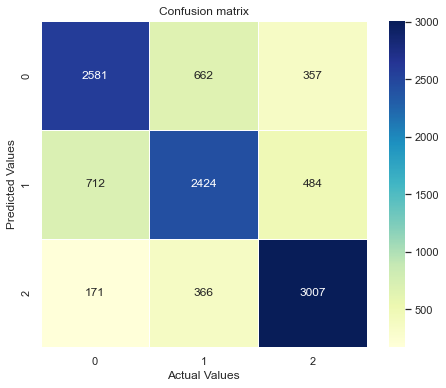

In [88]:
rf_clf_2 = RandomForestClassifier()
rf_clf_2.fit(X_train, y_train)
y_pred_rf2 = rf_clf_2.predict(X_test)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)
resultados(y_test, y_pred_rf2)

In [89]:
cols_model = X_train.columns
feature_importance= pd.DataFrame(list(zip(cols_model, rf_clf_2.feature_importances_.transpose())), columns = ['Col','Importance']).sort_values(by="Importance",ascending=False)
feature_importance

,Col,Importance
0,location,0.330501
3,volume,0.250851
2,log_feature,0.216093
1,event_type,0.098472
10,resource_type_2,0.026609
16,resource_type_8,0.021060
4,severity_type_1,0.019632
5,severity_type_2,0.015609
7,severity_type_4,0.008954
14,resource_type_6,0.003446
